# Inpainting

This notebook makes use of the inpainting method.

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.6/962.6 kB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 38.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
!pip install torchmetrics

import kagglehub
import os
import glob
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import numpy as np
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
import matplotlib.pyplot as plt

In [ ]:
path = kagglehub.dataset_download("ashwingupta3012/human-faces")

print("Dataset base path:", path)
print("Unterordner:", os.listdir(path))

image_dir = os.path.join(path, "Humans")

Dataset base path: /kaggle/input/human-faces
Unterordner: ['Humans']


In [ ]:
class InpaintingDataset(Dataset):
    def __init__(self, image_dir, size=128):
        self.paths = glob.glob(os.path.join(image_dir, "*.jpg"))  # Adjust if PNG etc.
        self.transform = T.Compose([
            T.Resize((size, size)),
            T.ToTensor()
        ])
        self.size = size

    def __getitem__(self, idx):
        image = Image.open(self.paths[idx]).convert("RGB")
        image = self.transform(image)
        mask = torch.ones_like(image)
        x1, y1 = np.random.randint(0, self.size//2, 2)
        x2, y2 = x1 + self.size//4, y1 + self.size//4
        mask[:, y1:y2, x1:x2] = 0  # zero out center region

        corrupted = image * mask
        return corrupted, image, mask

    def __len__(self):
        return len(self.paths)


In [ ]:
dataset = InpaintingDataset(image_dir=image_dir, size=128)
print("Images found:", len(dataset))


Images found: 6973


In [ ]:
class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()
        def block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.ReLU(),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.ReLU()
            )
        self.encoder1 = block(3, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = block(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.middle = block(128, 256)

        self.up1 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.decoder1 = block(256, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.decoder2 = block(128, 64)

        self.out = nn.Conv2d(64, 3, 1)

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool1(e1))
        m = self.middle(self.pool2(e2))
        d1 = self.decoder1(torch.cat([self.up1(m), e2], dim=1))
        d2 = self.decoder2(torch.cat([self.up2(d1), e1], dim=1))
        return self.out(d2)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = InpaintingDataset(image_dir=image_dir, size=128)
loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)

model = SimpleUNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def tv_loss(img):
    return torch.mean(torch.abs(img[:, :, :, :-1] - img[:, :, :, 1:])) + \
           torch.mean(torch.abs(img[:, :, :-1, :] - img[:, :, 1:, :]))

l1_loss_fn = nn.L1Loss()

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
import torch.nn.functional as F
from torchvision.models import vgg16
from torchvision.transforms import Normalize

# Load VGG16 feature extractor (up to relu3_3 or relu4_3, as needed)
class VGGPerceptualLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        vgg = vgg16(pretrained=True).features[:16]  # relu3_3
        for param in vgg.parameters():
            param.requires_grad = False
        self.vgg = vgg.to(device)
        self.normalize = Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])

    def forward(self, x, y):
        # Assume input in [0, 1]; normalize to match VGG input
        x = self.normalize(x)
        y = self.normalize(y)
        return F.l1_loss(self.vgg(x), self.vgg(y))

percep_loss_fn = VGGPerceptualLoss()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 80.2MB/s]


In [ ]:
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure

psnr_metric = PeakSignalNoiseRatio().to(device)
ssim_metric = StructuralSimilarityIndexMeasure().to(device)

lambda_l1 = 1.0
lambda_percep = 0.1
lambda_tv = 1e-5

epoch_losses = []
epoch_psnrs = []
epoch_ssims = []

for epoch in range(10):
    model.train()
    total_loss = 0
    total_psnr = 0
    total_ssim = 0
    count = 0

    for corrupted, original, mask in tqdm(loader, desc=f"Training Epoch {epoch+1}", leave=False):
        corrupted = corrupted.to(device)
        original = original.to(device)
        mask = mask.to(device)

        output = model(corrupted)

        # Rekonstruiertes Bild für perceptual loss (nur masked Bereich ersetzt)
        reconstructed = corrupted * mask + output * (1 - mask)

        # L1 loss nur auf maskierten Bereich
        masked_output = output * (1 - mask)
        masked_original = original * (1 - mask)
        l1 = F.l1_loss(masked_output, masked_original)

        # Perceptual loss auf rekonstruiertem Bild vs Original (global, aber maskensensitiv)
        perceptual = percep_loss_fn(reconstructed, original)

        # Total variation loss auf Output (optional: auch maskieren, wenn gewünscht)
        tv = tv_loss(output)

        # Gesamtverlust
        loss = lambda_l1 * l1 + lambda_percep * perceptual + lambda_tv * tv

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        with torch.no_grad():
            total_psnr += psnr_metric(output, original).item()
            total_ssim += ssim_metric(output, original).item()
            count += 1

    avg_loss = total_loss / count
    avg_psnr = total_psnr / count
    avg_ssim = total_ssim / count

    epoch_losses.append(avg_loss)
    epoch_psnrs.append(avg_psnr)
    epoch_ssims.append(avg_ssim)

    print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f} | PSNR: {avg_psnr:.2f} | SSIM: {avg_ssim:.4f}")



Epoch 1 - Loss: 0.0222 | PSNR: 21.99 | SSIM: 0.7947


Epoch 2 - Loss: 0.0212 | PSNR: 22.33 | SSIM: 0.8078


Epoch 3 - Loss: 0.0206 | PSNR: 22.23 | SSIM: 0.8090


Epoch 4 - Loss: 0.0202 | PSNR: 21.65 | SSIM: 0.8024


Epoch 5 - Loss: 0.0198 | PSNR: 21.22 | SSIM: 0.7968


Epoch 6 - Loss: 0.0195 | PSNR: 20.74 | SSIM: 0.7921


Epoch 7 - Loss: 0.0192 | PSNR: 20.25 | SSIM: 0.7888


Epoch 8 - Loss: 0.0188 | PSNR: 19.89 | SSIM: 0.7884


Epoch 9 - Loss: 0.0187 | PSNR: 19.58 | SSIM: 0.7848


Epoch 10 - Loss: 0.0186 | PSNR: 19.05 | SSIM: 0.7799


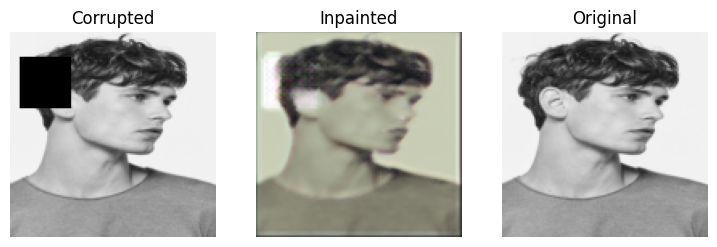

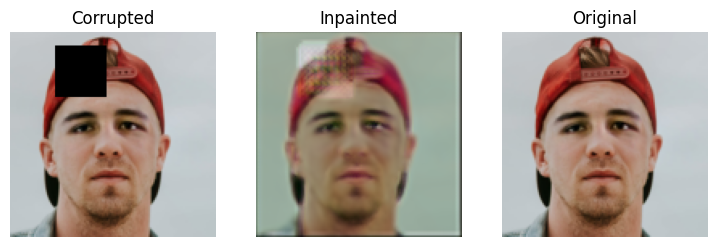

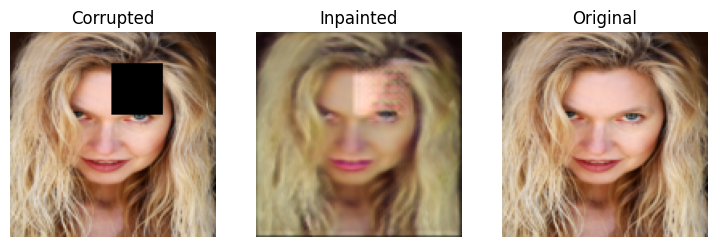

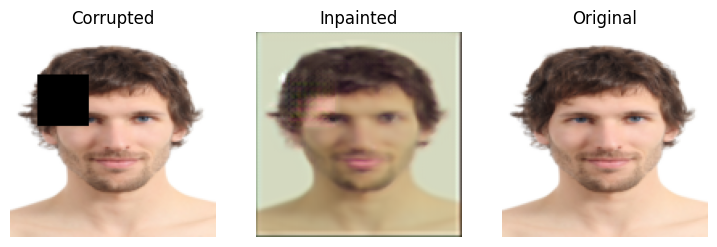

In [ ]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    corrupted, original, _ = next(iter(loader))
    corrupted = corrupted.to(device)
    output = model(corrupted).cpu()   #For plotting we need to work on the cpu.
    corrupted = corrupted.cpu()
    original = original.cpu()

    for i in range(4):
        fig, axs = plt.subplots(1, 3, figsize=(9, 3))
        axs[0].imshow(corrupted[i].permute(1, 2, 0))
        axs[0].set_title("Corrupted")
        axs[1].imshow(output[i].permute(1, 2, 0))
        axs[1].set_title("Inpainted")
        axs[2].imshow(original[i].permute(1, 2, 0))
        axs[2].set_title("Original")
        for ax in axs: ax.axis('off')
        plt.show()


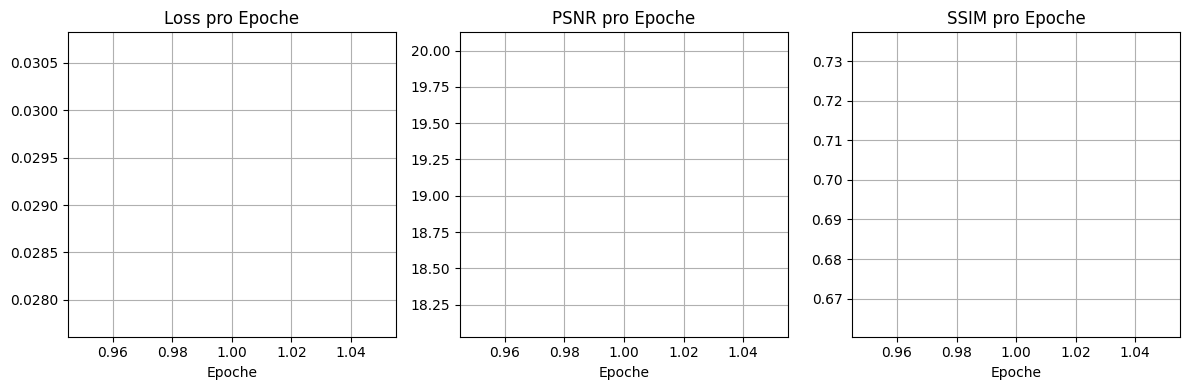

In [ ]:
epochs = range(1, len(epoch_losses) + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(epochs, epoch_losses, label='Loss')
plt.title('Loss pro Epoche')
plt.xlabel('Epoche')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(epochs, epoch_psnrs, label='PSNR', color='green')
plt.title('PSNR pro Epoche')
plt.xlabel('Epoche')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(epochs, epoch_ssims, label='SSIM', color='orange')
plt.title('SSIM pro Epoche')
plt.xlabel('Epoche')
plt.grid(True)

plt.tight_layout()
plt.show()
